In [1]:
#cluster as string
#Precision on kmeans
#Kmeans++
#Number of clusters
#best model?
#Explain kmenas
#silhouette and elbow
#normalizar as variáveis para não dar peso maior para variáveis com valores mais altos
#como usar as categoricas no kmeans?

# Train and Compare Machine Learning Models
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook will help you to do:
* Import train and test data
* Run many ML algorithms using H2O AutoML
* Compare all model performance in test dataset
* Choosing and save the best model

# 1. Parameters

In [3]:
#Name
ModelName = 'titanic_segmentation_model'

#Setting the VarId and VarDate parameters
VarId = 'PassengerId'
VarDate = 'ReferenceDate'

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1


#Version
ModelVersion = 'v1'

#Model ID
ModelId = ModelName+'_'+ModelVersion

#It is necessary to define the types of variables (cageroric and numeric) to ensure that the type of data used in the modeling will be the most suitable.
#For example, categorical variables need to be defined as a string because this prevents it from being treated as a numeric variable in H20 modeling
#Another example is that the string variables will have a missing treatment by placing the missing category for all values found as 'null'
CAT = ['Pclass'
,'Embarked'
,'cabine_prefix'
,'Ticket_str'
,'NameTitle']

#float
NUM = ['Fare'
,'SibSp'
,'Parch'
,'Age_Mean'
,'Ticket_int']
selected_features = CAT + NUM

# 2. Import Libraries

In [4]:
import functools
import os
from time import gmtime, strftime, sleep
import datetime as dt
import pandas as pd
import numpy as np
import glob
import h2o
import matplotlib.pyplot as plt
from sklearn import metrics
import shutil
import seaborn as sns
from io import StringIO
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 3. Importing Data for Modeling

In [5]:
dataprep_df_full = pd.read_csv('./titanic/dataprep_df.csv')

In [6]:
dataprep_df_full.head()

,Pclass,Embarked,cabine_prefix,Ticket_str,NameTitle,Fare,SibSp,Parch,Age_Mean,Ticket_int,PassengerId,ReferenceDate,dataset
0,3,S,missing,A,Mr,7.2500,1.0,0.0,22.0,521171.0,1,1912-05,train
1,1,C,C,PC,Mrs,71.2833,1.0,0.0,38.0,17599.0,2,1912-04,train
2,3,S,missing,STONO,Miss,7.9250,0.0,0.0,26.0,23101282.0,3,1912-06,train
3,1,S,C,missing,Mrs,53.1000,1.0,0.0,35.0,113803.0,4,1912-04,train
4,3,S,missing,missing,Mr,8.0500,0.0,0.0,35.0,373450.0,5,1912-07,test


In [7]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    dataprep_df = dataprep_df_full.copy()
else:
    dataprep_df = dataprep_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)
del dataprep_df_full

In [8]:
#Numeric features must be float type
for col_name in NUM:
    dataprep_df[col_name] = dataprep_df[col_name].astype(float)

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:
    dataprep_df[col_name] = dataprep_df[col_name].astype(str)

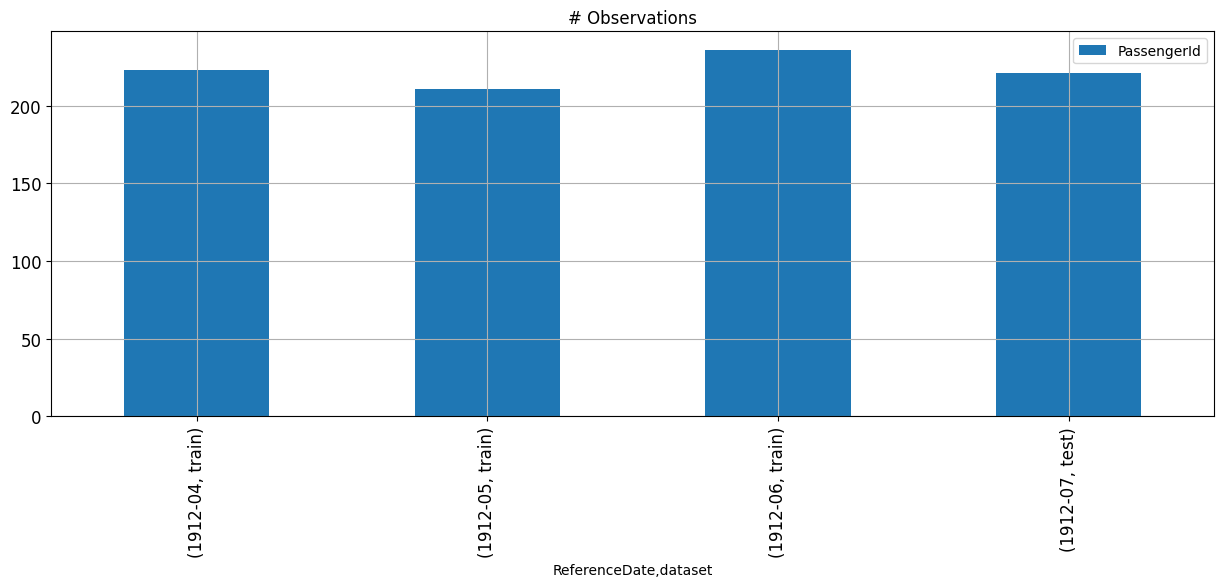

In [10]:
#plot the final dataset with time period, train and test definitions
dataprep_target = dataprep_df[[VarDate, VarId, 'dataset']].groupby(by=[VarDate, 'dataset']).agg({VarId:'count'})
dataprep_target[VarId].plot(secondary_y=False, kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=("# Observations"))

## 3.1 Treatment of Numeric Missing Data

In [11]:
#Create the "Missing" category for missing values in string vaviables
# dataprep_df = dataprep_df.apply(lambda x: x.fillna(np.nan) if x.dtype.kind in 'biufc' else x.fillna('Missing'))

In [12]:
#Tratamento da idade
# dataprep_df['age_mean'] = dataprep_df['age'].fillna(dataprep_df['age'].mean())

## 3.2 Outliers Removing

In [13]:
# var = 'max_salary_offered_to_prev_application'

# q_low = dataprep_df[var].quantile(0.00012)
# q_hi  = dataprep_df[var].quantile(0.9999)
# print('Low: ' + str(q_low))
# print('High: ' + str(q_hi))
# print('Reduction: ' 
#       + "{0:.2%}".format(len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])/len(dataprep_df)-1) 
#       + " | " 
#       + str(len(dataprep_df)-len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])))

# def plot_comparison(x, title, low, high):
#     fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15,5))
#     fig.suptitle(title, fontsize=16)
#     sns.distplot(x.rename(""), ax=ax[0])
#     ax[0].set_title('Histogram + KDE')
#     sns.boxplot(x.rename(""), ax=ax[1])
#     ax[1].set_title('Boxplot')
#     sns.violinplot(x.rename(""), ax=ax[2])
#     ax[2].set_title('Violin plot')
#     # only one line may be specified; full height
#     ax[1].axvline(x = low, color = 'red')
#     ax[1].axvline(x = high, color = 'red')
#     plt.show()
    
# plot_comparison(dataprep_df[var], var, q_low, q_hi)

# dataprep_df = dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)]

# 4. Modeling

## 4.1 Traning Models with H2O AutoML

## 4.1.1 Creating context and H2O and Importing data into the H2O context

In [14]:
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 5 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,4 months and 9 days !!!
H2O_cluster_name:,H2O_from_python_azureuser_khend1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,879 Mb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [15]:
#Import TRAINING base to the H20 context
data_hdf = h2o.H2OFrame(dataprep_df.query('dataset == "train"').loc[:, (selected_features)])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
for col_name in CAT:
    data_hdf[col_name] = data_hdf[col_name].asfactor()
for col_name in NUM:
    data_hdf[col_name] = data_hdf[col_name].asnumeric()
    
# Partition data into 90%, 10% chunks
# Setting a seed will guarantee reproducibility
train_hdf, valid_hdf = data_hdf.split_frame(ratios=[0.90], destination_frames=['train_hdf', 'valid_hdf'], seed=1)
        
#Notice that `split_frame()` uses approximate splitting not exact splitting (for efficiency), so these are not exactly 90%, 10% of the total rows.
print('Training: ' + str(train_hdf.nrow))
print('Validation: ' + str(valid_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training: 606
Validation: 64


In [16]:
#Import TEST base to the H20 context
test_hdf = h2o.H2OFrame(dataprep_df.query('dataset == "test"').loc[:, (selected_features)])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
for col_name in CAT:
    test_hdf[col_name] = test_hdf[col_name].asfactor()
for col_name in NUM:
    test_hdf[col_name] = test_hdf[col_name].asnumeric()
    
print('Test: ' + str(test_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Test: 221


## 4.2.2 Train the H2O Champion algorithm with new data

In [17]:
## This is the champion previous trained algorithms that will be used as comparison for the new experiments
vModel='H2O_KMeans_'

#Execution time of the model
start = dt.datetime.now()

from h2o.estimators import H2OKMeansEstimator
kmeans = H2OKMeansEstimator(k=10,
                                 estimate_k=True,
                                 standardize=False,
                                 seed=1)

# The use of a validation_frame is recommended
kmeans.train(x=selected_features,
                  training_frame=train_hdf,
                  validation_frame=valid_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")
print(kmeans)

kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%

Execution time: 0:00:00.403965

Model Details
H2OKMeansEstimator :  K-means
Model Key:  KMeans_model_python_1668728855663_5048


Model Summary: 


,,number_of_rows,number_of_clusters,number_of_categorical_columns,number_of_iterations,within_cluster_sum_of_squares,total_sum_of_squares,between_cluster_sum_of_squares
0,,606.0,10.0,5.0,31.0,4.468405e+10,8.299802e+15,8.299757e+15




ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 44684050874.97753
Total Sum of Square Error to Grand Mean: 8299802181159371.0
Between Cluster Sum of Square Error: 8299757497108496.0

Centroid Statistics: 


,,centroid,size,within_cluster_sum_of_squares
0,,1.0,149.0,3.006991e+09
1,,2.0,16.0,1.542537e+03
2,,3.0,18.0,1.078572e+04
3,,4.0,61.0,6.029695e+09
4,,5.0,118.0,1.277404e+10
5,,6.0,59.0,6.106586e+09
6,,7.0,5.0,7.235110e+08
7,,8.0,45.0,7.066099e+07
8,,9.0,5.0,1.140274e+08
9,,10.0,130.0,1.585853e+10



ModelMetricsClustering: kmeans
** Reported on validation data. **

Total Within Cluster Sum of Square Error: 7659539640.780108
Total Sum of Square Error to Grand Mean: 1506660021580.7278
Between Cluster Sum of Square Error: 1499000481939.9478

Centroid Statistics: 


,,centroid,size,within_cluster_sum_of_squares
0,,1.0,15.0,4.307627e+08
1,,2.0,0.0,0.000000e+00
2,,3.0,0.0,0.000000e+00
3,,4.0,10.0,1.133207e+09
4,,5.0,15.0,3.979717e+09
5,,6.0,3.0,1.998292e+08
6,,7.0,1.0,3.717801e+08
7,,8.0,6.0,8.468624e+06
8,,9.0,1.0,3.316612e+07
9,,10.0,13.0,1.502609e+09



Scoring History: 


,,timestamp,duration,iterations,number_of_clusters,number_of_reassigned_observations,within_cluster_sum_of_squares
0,,2022-11-18 00:54:04,0.028 sec,0.0,0.0,NaN,NaN
1,,2022-11-18 00:54:04,0.081 sec,1.0,1.0,606.0,8.454791e+15
2,,2022-11-18 00:54:04,0.091 sec,2.0,1.0,0.0,8.299802e+15
3,,2022-11-18 00:54:04,0.105 sec,3.0,2.0,18.0,1.963635e+15
4,,2022-11-18 00:54:04,0.113 sec,4.0,2.0,0.0,1.651138e+14
5,,2022-11-18 00:54:04,0.121 sec,5.0,3.0,19.0,1.262178e+14
6,,2022-11-18 00:54:04,0.123 sec,6.0,3.0,10.0,1.258677e+14
7,,2022-11-18 00:54:04,0.125 sec,7.0,3.0,96.0,1.252469e+14
8,,2022-11-18 00:54:04,0.127 sec,8.0,3.0,71.0,9.902435e+13
9,,2022-11-18 00:54:04,0.128 sec,9.0,3.0,0.0,1.411429e+13



See the whole table with table.as_data_frame()



In [18]:
perf = kmeans.model_performance()
perf


ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 44684050874.97753
Total Sum of Square Error to Grand Mean: 8299802181159371.0
Between Cluster Sum of Square Error: 8299757497108496.0

Centroid Statistics: 


,,centroid,size,within_cluster_sum_of_squares
0,,1.0,149.0,3.006991e+09
1,,2.0,16.0,1.542537e+03
2,,3.0,18.0,1.078572e+04
3,,4.0,61.0,6.029695e+09
4,,5.0,118.0,1.277404e+10
5,,6.0,59.0,6.106586e+09
6,,7.0,5.0,7.235110e+08
7,,8.0,45.0,7.066099e+07
8,,9.0,5.0,1.140274e+08
9,,10.0,130.0,1.585853e+10


In [19]:
#Consider all models in the history ./models/candidates/performance_*.csv. To disregard any old version, set erase_modelos = "S":
apagar_modelos = 'N'
if apagar_modelos == 'S':
    os.system('rm %s/models/candidates/performance_*.csv' % OutputPath)

In [20]:
h2o.save_model(model=kmeans, path='%s/models/candidates/' % OutputPath, force=True)

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/maxdez1/code/Users/maxdez/FIEP-Machine-Learning-e-Computacao-em-Nuvem/output_model/models/candidates/KMeans_model_python_1668728855663_5048'

# 5. Exporting the best model to Deploy (Usar o path_model_mojo para o código 3_Explaining_Model.ipynb)

In [21]:
try:
    #Save the H2O model in MOJO format and all the variables of the best model
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, kmeans.model_id))
    path_model_mojo = melhor_modelo.download_mojo('%s/models/best/' % OutputPath, get_genmodel_jar=True)
    print('path_model_mojo: ' + str(path_model_mojo))
    caminho_modelo_h2o = h2o.save_model(model=melhor_modelo, path='%s/models/best/' % OutputPath, force=True)
except Exception as e:
    print(e)

path_model_mojo: /mnt/batch/tasks/shared/LS_root/mounts/clusters/maxdez1/code/Users/maxdez/FIEP-Machine-Learning-e-Computacao-em-Nuvem/clusters_segmentation/output_model/models/best/KMeans_model_python_1668728855663_5048.zip


In [23]:
#Confusion Matrix for the Champion
df_cluster_tmp = h2o.mojo_predict_pandas(dataprep_df.loc[:, (selected_features)], mojo_zip_path=path_model_mojo, verbose=False)

df_cluster = pd.concat([df_cluster_tmp.reset_index(drop=True), dataprep_df.loc[:, (selected_features+['dataset'])].reset_index(drop=True)], axis=1)
# df_cluster['cluster'] = df_cluster['cluster'] + 1
df_cluster['cluster'] = df_cluster['cluster'].astype(int)

df_cluster

Detected 1 unused columns in the input data set: {}


,cluster,Pclass,Embarked,cabine_prefix,Ticket_str,NameTitle,Fare,SibSp,Parch,Age_Mean,Ticket_int,dataset
0,8,3,S,missing,A,Mr,7.2500,1.0,0.0,22.000000,521171.0,train
1,9,1,C,C,PC,Mrs,71.2833,1.0,0.0,38.000000,17599.0,train
2,1,3,S,missing,STONO,Miss,7.9250,0.0,0.0,26.000000,23101282.0,train
3,7,1,S,C,missing,Mrs,53.1000,1.0,0.0,35.000000,113803.0,train
4,5,3,S,missing,missing,Mr,8.0500,0.0,0.0,35.000000,373450.0,test
...,...,...,...,...,...,...,...,...,...,...,...,...
886,3,2,S,missing,missing,LOW,13.0000,0.0,0.0,27.000000,211536.0,train
887,7,1,S,B,missing,Miss,30.0000,0.0,0.0,19.000000,112053.0,train
888,0,3,S,missing,WC,Miss,23.4500,1.0,2.0,29.699118,6607.0,train
889,7,1,C,C,missing,Mr,30.0000,0.0,0.0,26.000000,111369.0,test


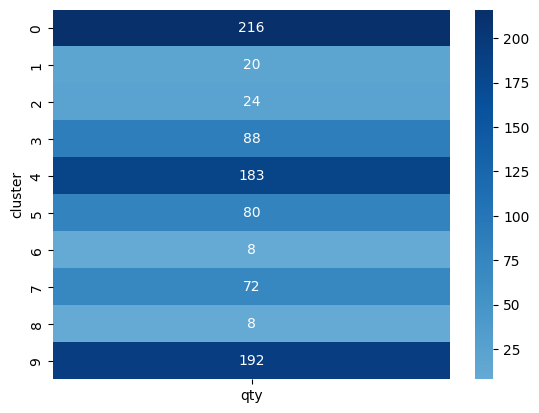

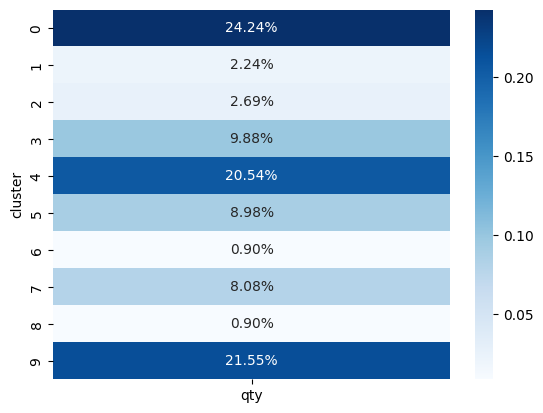

In [24]:
df_cluster_plot = df_cluster.reset_index().groupby(['cluster']).count()[['index']].rename(columns={'index': 'qty'})
sns.heatmap(df_cluster_plot, annot=True, center=True,cmap='Blues', fmt='g')
plt.show()
sns.heatmap(df_cluster_plot/np.sum(df_cluster_plot), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

# 6. Save final dataset with predictions into S3 to explain the model

In [53]:
csv_buffer = StringIO()
df_cluster.to_csv(csv_buffer, index=False, header=True)
s3_resource = my_boto3_session.resource('s3')
s3_resource.Object(bucket, 'databases/%s/%s.csv' % (ModelName+'_scored', ModelName+'_scored')).put(Body=csv_buffer.getvalue())
del csv_buffer

In [54]:
#Include Glue delete table before start the crawler
glue = my_boto3_session.client('glue', region_name="us-east-1")

try:
    glue.delete_table(
        DatabaseName='nowapp',
        Name=ModelName+'_scored'
    )
except:
    print("OK: The table doesn't exist yet. It is not necessary to delete it.")

glue.update_crawler(Name='nowapp',
                    Targets={'S3Targets': [{'Path': 's3://%s/databases/%s' % (bucket, ModelName+'_scored'),
                               'Exclusions': []}]})

glue.start_crawler(Name='nowapp')

{'ResponseMetadata': {'RequestId': '2d5c480a-8c82-4753-b116-cbe5f6505c54',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Thu, 17 Nov 2022 20:00:53 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '2d5c480a-8c82-4753-b116-cbe5f6505c54'},
  'RetryAttempts': 0}}